In [15]:
from torch.utils.data import Dataset, DataLoader
import torch
import torch.nn as nn
import numpy as np
import os
from pathlib import Path
import sys
import seaborn as sns
import matplotlib.pyplot as plt
from umap import UMAP


tri_path = os.environ.get('TRIPATH_DIR')
if tri_path and tri_path not in sys.path:
    sys.path.append(tri_path)
from models.feature_extractor import swin3d_b
from tqdm import tqdm


In [2]:
class PatchDataset(Dataset):
    def __init__(self, paths):
        self.paths = paths

    def __len__(self):
        return len(self.paths)

    def __getitem__(self, idx):
        path = self.paths[idx]
        patch = np.load(path)
        patch = torch.from_numpy(patch).float()
        patch = patch.unsqueeze(0)
        patch = patch.repeat(3,1,1,1)
        return patch, str(path)

In [3]:
class PatchEncoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = swin3d_b()
        self.encoder.load_weights()

    def forward(self, x):
        x = self.encoder(x)
        return x

In [4]:
data_dir = Path(os.environ['DATA_DIR'])
patch_dir = data_dir / "patches"
paths = list(patch_dir.rglob("*.npy"))
dataset = PatchDataset(paths)
dataloader = DataLoader(dataset, batch_size=32, shuffle=False)
encoder = PatchEncoder()

Loading pretrained video weights


In [5]:
for i, (patch, path) in enumerate(tqdm(dataloader)):
    with torch.no_grad():
        patch = encoder(patch)
    for p, pth in zip(patch, path):
        pth = Path(pth)
        save_path = pth.parent.parent / "embeddings" / (pth.parent.name + "_" + pth.stem + ".pt")
        if not save_path.parent.exists():
            save_path.parent.mkdir()
        torch.save(p, save_path)


100%|██████████| 39/39 [00:51<00:00,  1.33s/it]


In [6]:
class EmbeddingDataset(Dataset):
    def __init__(self, dir):
        self.dir = Path(dir)
        self.paths = list(dir.rglob("*.pt"))
        self.embeddings = [torch.load(p) for p in self.paths]
        self.labels = [self.paths]
        self.labels = [path.name.split("_")[0] for path in self.paths]

    def __len__(self):
        return len(self.paths)

    def __getitem__(self, idx):
        embedding = self.embeddings[idx]
        label = self.labels[idx]
        return embedding, label

In [8]:
dataset = EmbeddingDataset(data_dir / "patches" / "embeddings")
loader = DataLoader(dataset, batch_size=len(dataset), shuffle=False)
embeddings, labels = next(loader.__iter__())
embeddings

/tmp/ipykernel_4166704/3631862905.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.embeddings = [torch.load(p) for p in self.paths]


tensor([[-0.3251, -0.0722, -0.1495,  ...,  0.2384, -0.3426, -0.1097],
        [-0.3980, -0.0031, -0.1454,  ...,  0.0954, -0.4067, -0.0830],
        [-0.3978,  0.0882, -0.1419,  ...,  0.2528, -0.2689, -0.0229],
        ...,
        [-0.5678, -0.0132, -0.1414,  ...,  0.2360, -0.3147,  0.0654],
        [-0.5028,  0.1275, -0.1574,  ..., -0.0012, -0.6176,  0.2696],
        [-0.4711,  0.0757, -0.1437,  ...,  0.2718, -0.2940,  0.0960]])

In [10]:
umap = UMAP()
umap_embeddings = umap.fit_transform(embeddings)

<Axes: >

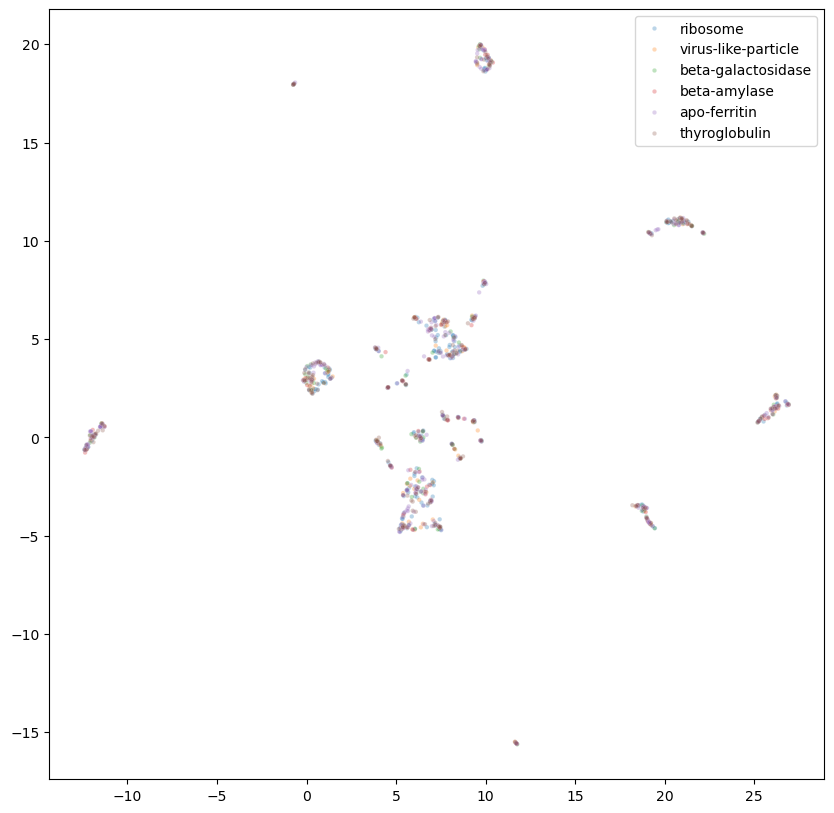

In [19]:
plt.figure(figsize=(10, 10))
sns.scatterplot(x=umap_embeddings[:, 0], y=umap_embeddings[:, 1], hue=labels, alpha=0.3, s=10)